In [1]:
# Library for linear algebra
import numpy as np
from numpy import random
# Library and functions for the plots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.image import NonUniformImage
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
# Library for precompiled (and faster) code
import numba as numba
from numba import njit
# Linrary for optimization
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
# Other useful libraries
import re
import time

In [2]:
## Load potential, force and state
from System_informations2 import potential, force, state, start_pos
## Load committors
from Committor2 import ListGuess, ListdGuess

In [3]:
def fmt(x, pos):
    # format for colorbars tick labels
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

@njit(fastmath=True, cache=True)
def LangM(ncomm, q0, tstep, temperature, isteps):
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q_trans = np.empty((isteps, 2), dtype=np.float64)
    M = np.empty((isteps, ncomm, ncomm), dtype=np.float64)
    dGx = np.empty(ncomm, dtype=np.float64)
    dGy = np.empty(ncomm, dtype=np.float64)
    # Initial conditions
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    # Diffusion coefficient
    Dt = np.sqrt(2.0*temperature*tstep)
    # Index for the transition trajectory
    j = 0
    for i in range(isteps-1):
        # Evaluate evolution of the system
        fx, fy=force(q[i,0], q[i,1])
        q[i+1,0] = q[i,0]+fx*tstep+Dt*np.random.normal(0,1)
        q[i+1,1] = q[i,1]+fy*tstep+Dt*np.random.normal(0,1)
        if state(q[i+1,0],q[i+1,1]) == 0:
            # Gradient components of the committors
            for k in range(ncomm):
                dGx[k], dGy[k] = ListdGuess(k, q[i+1,0], q[i+1,1])  
            # Evaluating M Matrix
            for k in range(ncomm):
                for l in range(ncomm):
                    M[j,k,l] = dGx[k]*dGx[l]+dGy[k]*dGy[l]
            q_trans[j,:] = q[i+1,:]
            j+=1
            
    if j == 0:
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        outM = np.empty((1, ncomm, ncomm), dtype=np.float64)
        for k in range(ncomm):
            for l in range(ncomm):
                outM[i,k,l] = 0.0
        return out, outM
    
    else:
        return q_trans[:j,:], M[:j,:,:]

@njit(fastmath=True, cache=True)
def RatchetLang(c, q0, tstep, temperature, kr, isteps):
    ## Number of committor functions given as input
    ncomm = len(c)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    dGx = np.empty(ncomm, dtype=np.float64)
    dGy = np.empty(ncomm, dtype=np.float64)
    # Assign initial position to the border of the reactant state
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    # Incremental variables in the loop
    i = 0
    j = 0
    tmp = 0
    # State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    s = state(q[0,0],q[1,1]) 
    zmax = 0.0
    # Diffusion coefficient
    Dt = np.sqrt(2.0*temperature*tstep)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        # Evaluate evolution of the system
        fx, fy = force(q[i,0],q[i,1])
        # Evaluate z
        z = 0.0
        for k in range(ncomm):
            z += c[k]*ListGuess(k, q[i,0], q[i,1])
        # Gradient components of the committors
        for k in range(ncomm):
            dGx[k], dGy[k] = ListdGuess(k, q[i,0], q[i,1]) 
        # Dynamics
        if z > zmax:
            q[i+1,0] = q[i,0]+fx*tstep+Dt*np.random.normal(0,1)
            q[i+1,1] = q[i,1]+fy*tstep+Dt*np.random.normal(0,1)
            zmax = z
        else:
            ratchetx = 0.0
            ratchety = 0.0
            for k in range(ncomm):
                ratchetx += c[k]*dGx[k]
                ratchety += c[k]*dGy[k]
            q[i+1,0] = q[i,0]+fx*tstep+Dt*np.random.normal(0,1)+kr*ratchetx*(zmax - z)*tstep
            q[i+1,1] = q[i,1]+fy*tstep+Dt*np.random.normal(0,1)+kr*ratchety*(zmax - z)*tstep
        i += 1
        s = state(q[i,0],q[i,1])
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        return out
        
    return q[j+1:i-1,:]

In [4]:
## Parameters of the run
ncomm=3              # Number of guess committors
temperature=1.0      # Temperature
tstep=0.005           # time interval for MD simulations
kratchet=150         # Force constant of the ratchet
MDsteps=15000        # Maximum number of steps fo MD simulations
biassim=2000         # Number of bias simulations used to sample transition region
relax=20              # How often do we pick a point of a biased trajectory as starting point of a MD trajectory
    
        
## Limits of the plots
xlimleft=-2.0
xlimright=2.0
ylimdown=-1.5
ylimup=2.5
delta=0.025
    
## Parameters of plots
axisticslabelfontsize=9
axisticslabelfontsizeinset=7
axislabelfontsize=11
axislabelfontsizeinset=9
legendfontsize=7
lineswidth = 2
ncontour = 25
cmap = plt.get_cmap('RdBu')    

In [5]:
c = [4.19593774e-06, 9.99042969e-01, 9.52834889e-04]
nameprob = "Prob.pdf"

In [6]:
tmp = 0
for j in range(biassim):
    q0 = start_pos()
    biastraj = RatchetLang(c, q0, tstep, temperature, kratchet, MDsteps)
    if biastraj[0,0] != 0.0 and biastraj[0,1] != 0.0:
        q0Lang = biastraj[1::5,:]
        for i in range(q0Lang.shape[0]):
            traj, M = LangM(ncomm, q0Lang[i,:], tstep, temperature, relax)  # I run the integrator
            if traj[0,0] != 0 and traj[0,1] != 0:
                if tmp==0:
                    trajall = np.copy(traj)
                    Mall = np.copy(M)
                    tmp = 1
                if tmp==1:
                    trajall = np.concatenate((trajall, traj), axis=0)
                    Mall = np.concatenate((Mall, M), axis=0)
                del traj, M
        del biastraj 
            
M = np.zeros((ncomm,ncomm), dtype=np.float64)
# Average all the values of M
for k in range(Mall.shape[0]):
    for i in range(ncomm):
        for j in range(ncomm):
            M[i,j] += Mall[k,i,j]

# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
            
## Evaluate the rate 
rate = 0.0
for i in range(ncomm):
    for j in range(ncomm):
        rate += M[i,j]*c[i]*c[j]
rate *= np.sqrt(2.0*temperature)
print("Rate of optimal linear combination: ", rate)

Rate of optimal linear combination:  0.14721764786603828


In [7]:
## Prepare the contour lines for the potential and the basins
xcontour = np.arange(xlimleft,xlimright, 0.025)
ycontour = np.arange(ylimdown,ylimup, 0.025)
X, Y = np.meshgrid(xcontour, ycontour)
# Potential
CONT = X*0
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        CONT[i,j] = potential(X[i,j],Y[i,j])
# Basins
BASINS = X*0
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        BASINS[i,j] = state(X[i,j],Y[i,j])
levelsb = [-1.0, 0.0 ,1.0] 
    
## Prepare the grid for the plots
yplot, xplot = np.mgrid[slice(ylimdown, ylimup + delta, delta),slice(xlimleft, xlimright + delta, delta)]

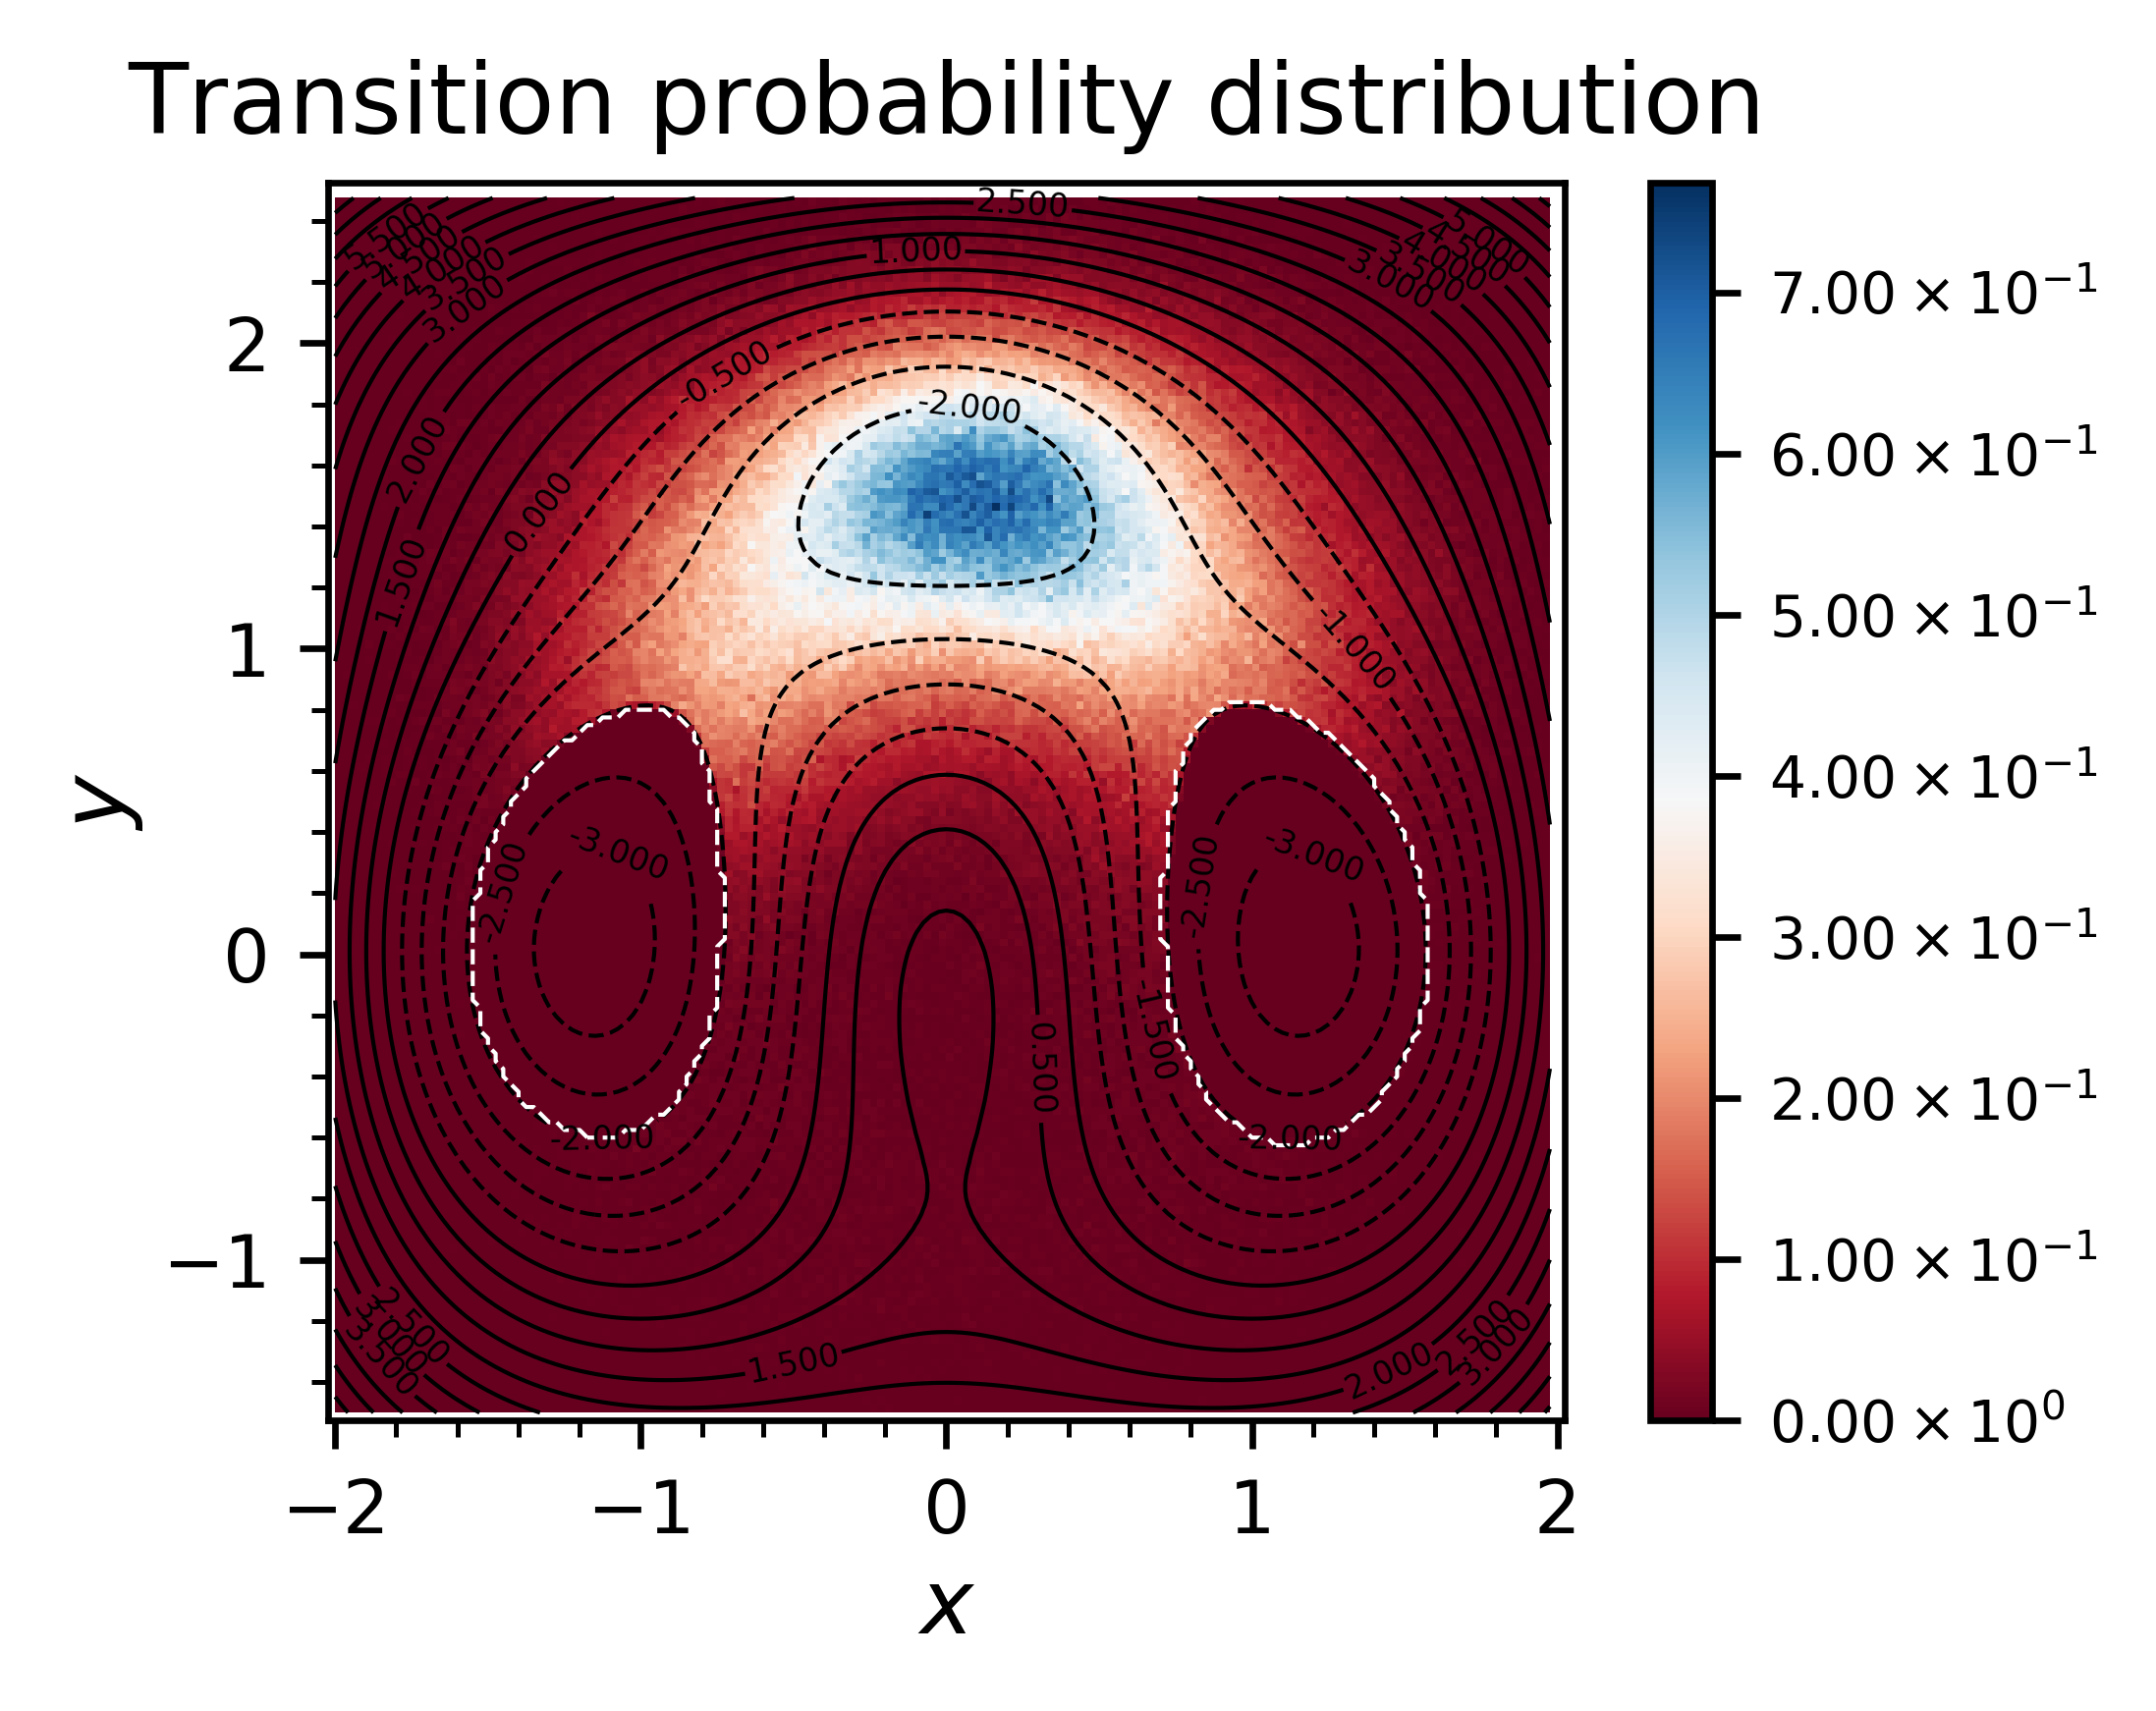

In [8]:
with PdfPages(nameprob) as pdf:
    fmt1 = '%r %%'
    fig = plt.figure(figsize=(4.,2.8),dpi=600)
    plt.rc('text')
    panel = fig.add_axes([0.15, 0.15, 0.72, 0.75]) # dimensions and location of the panel within the figure
    # Borders of the plot
    xedges = np.arange(xlimleft,xlimright, delta).tolist()
    yedges = np.arange(ylimdown,ylimup, delta).tolist()
    # Create the histogram
    H, xedges, yedges = np.histogram2d(trajall[:,0], trajall[:,1], bins=(xedges, yedges), density = True)
    H = H.T  # Let each row list bins with common y range.
    pcm = panel.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    cbar = plt.colorbar(pcm,format=ticker.FuncFormatter(fmt)) # plot colorbar and select format
    cbar.ax.tick_params(labelsize=axisticslabelfontsize-2) # dimension of the labels of the colorbar
    pcm.set_cmap('RdBu')
    panel.set_xlabel(r'$x$',fontsize=axislabelfontsize,labelpad=2) # labels and ticklabels along x with their fontsize and location, x limits and same for y below
    for tick in panel.xaxis.get_major_ticks(): tick.label.set_fontsize(axisticslabelfontsize)
    panel.set_xlim(xlimleft-delta,xlimright+delta)
    panel.xaxis.set_major_locator(MultipleLocator(1))
    panel.xaxis.set_minor_locator(MultipleLocator(0.2))
    panel.set_ylabel(r'$y$',fontsize=axislabelfontsize,labelpad=2)
    for tick in panel.yaxis.get_major_ticks(): tick.label.set_fontsize(axisticslabelfontsize)
    panel.set_ylim(ylimdown-delta,ylimup+delta)
    panel.yaxis.set_major_locator(MultipleLocator(1))
    panel.yaxis.set_minor_locator(MultipleLocator(0.2))
    # Potential 
    CS = panel.contour(X, Y, CONT, ncontour, colors='k', linewidths = 0.5)
    plt.clabel(CS, fontsize=4, inline=1)
    contour = panel.contour(X, Y, BASINS,levels=levelsb,colors="white",linewidths = 0.5, linestyles='dashed')
    plt.title("Transition probability distribution") # title
    plt.show()
    pdf.savefig(fig)